## Advanced Lane Lines Project

### 1. Camera Calibration

There are two types of distortion that can be introduced by a camera:
1. Radial distortion: light bends a little TOO MUCH or TOO LITTLE at the edge of lenses.
2. Tangential distortion: camera's lense is not aligned perfectly parallel to the imaging plane.

In order to correct distortion, we need to calculate the correct camera matrix and distortion coefficients. This can be done by using the calibration chessboard (9x6) images.

After the matrix and coeeficients are calculated, we gonna use them to undistort an image to demonstrate their correctness. 

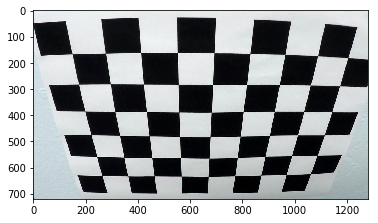

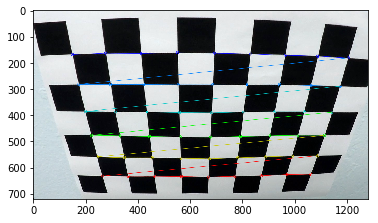

In [135]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx = 9
ny = 6

# Read in an image
file = './camera_cal/calibration2.jpg'
image = cv2.imread(file)
plt.imshow(image)
plt.show()

# Find the corners in the chessboard
ret, corners = cv2.findChessboardCorners(image, (nx, ny), None)
if ret:
    # If found, draw chessboard corners
    out = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.imshow(out)
    plt.show()

Read all calibration images, calculate matrix and distortion coefficients and display the undistortion images.

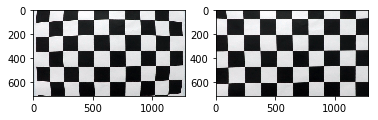

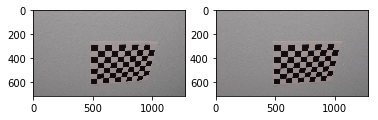

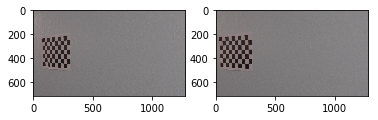

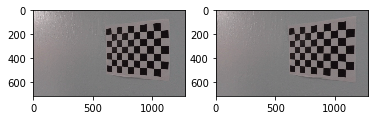

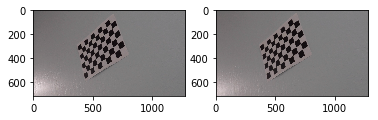

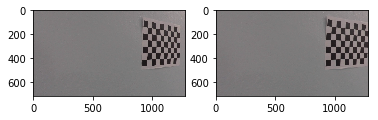

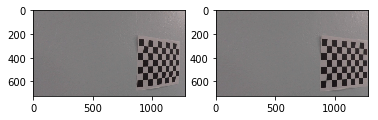

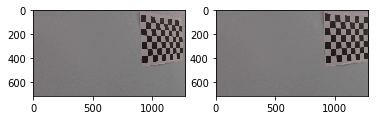

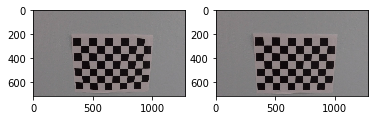

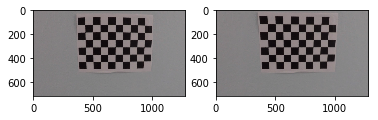

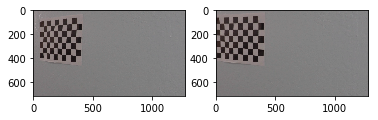

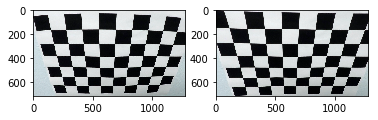

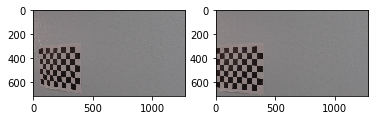

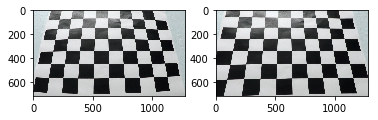

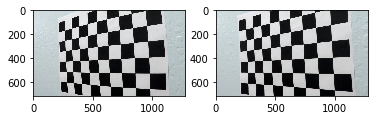

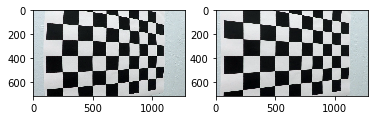

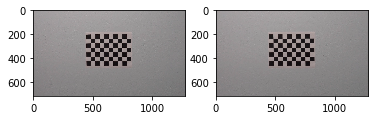

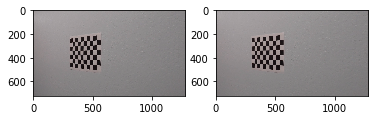

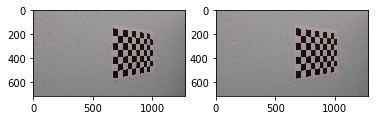

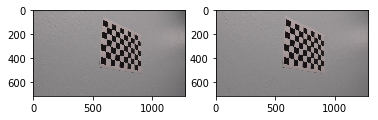

In [136]:
import glob

nx = 9
ny = 6

objpoints = []
imgpoints = []

# Generate object point
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x,y coordinates

files = glob.glob('./camera_cal/calibration*.jpg')

for file in files:
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
for file in files:
    image = cv2.imread(file)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(undistort_img)
    plt.show()

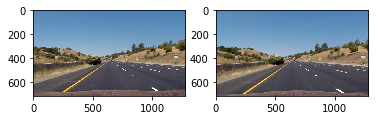

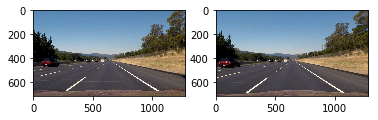

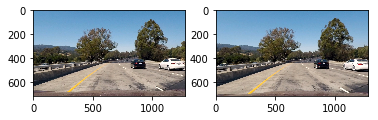

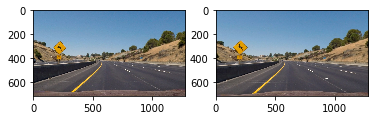

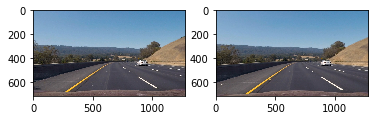

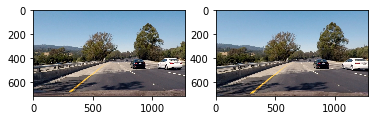

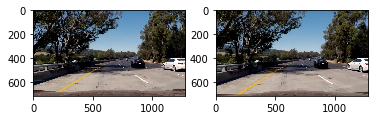

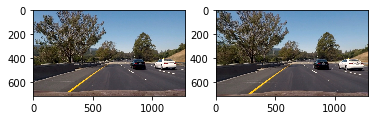

In [137]:
# Apply matrix to test images

images = []
files = glob.glob('./test_images/*.jpg')
for file in files:
    image = mpimg.imread(file)
    undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(image)
    fig.add_subplot(1,2,2)
    plt.imshow(undistort_img)
    plt.show()
    images.append(undistort_img)

### 2. Create Threshold Binary Images

Use various technologies (e.g. color space transforms and Sobel gradients) to create binary images containing lane pixels.

#### 2.1 Color selection

Firstly, let's take an image and compare the performance of each channel in HLS and HSV color space:

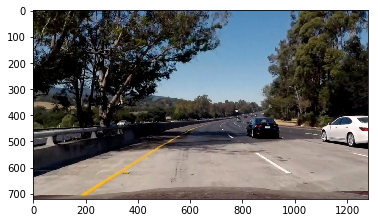

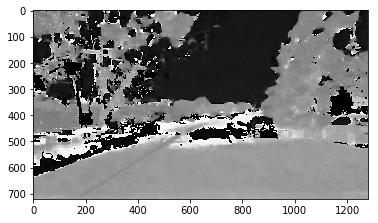

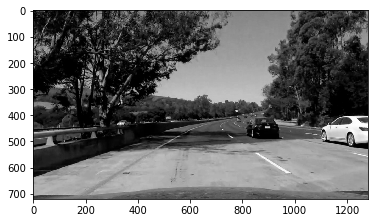

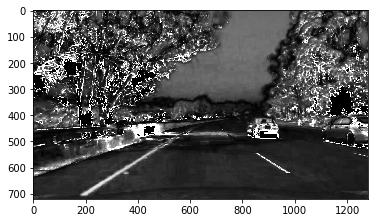

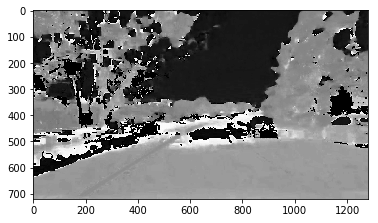

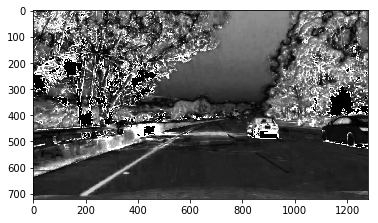

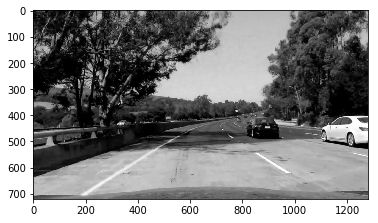

In [138]:
img = images[6]

plt.imshow(img)
plt.show()

hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
for i in range(3):
    plt.imshow(hls_img[:,:,i], cmap='gray')
    plt.show()
    
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
for i in range(3):
    plt.imshow(hsv_img[:,:,i], cmap='gray')
    plt.show()

After visually checked all test images, I found S channel in HLS color space output a stable and better result. I then define a color threshold function to filter the image.

In [230]:
def color_thresh(img, s_thresh=(0, 255), r_thresh=(0,255)):
    # Deal with yellow
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #plt.imshow(s_binary, cmap = 'gray')
    #plt.show()
    
    # Deal with white
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    #plt.imshow(r_binary, cmap = 'gray')
    #plt.show()
    
    binary = np.zeros_like(s_channel)
    binary[(s_binary == 1) | (r_binary == 1)] = 1
    return binary

#### 2.2 Gradient Selection

Now let's take a look at the gradient method. I use Sobel gradient and want to check the binary image of these 4 operations: sobel-x, sobel-y, sobel magnitude, sobel direction.

In [140]:
def abs_sobel(img, sobel_kernel=3):
    '''Apply Sobel operator to an image and return absolute value of sobel value on x and y direction'''
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    return abs_sobel_x, abs_sobel_y

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate sobel x and y and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    if orient == 'x':
        sobel = abs_sobel_x
    if orient == 'y':
        sobel = abs_sobel_y
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    '''Calculate gradient magnitude and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    scaled_gradmag = np.uint8(255 * gradmag / np.max(gradmag))
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= mag_thresh[0]) & (scaled_gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and filter result'''
    abs_sobel_x, abs_sobel_y = abs_sobel(img, sobel_kernel)
    graddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    dir_binary = np.zeros_like(graddir)
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

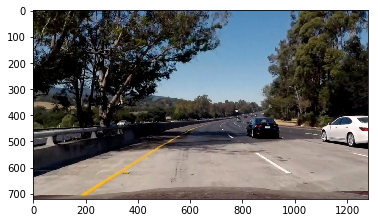

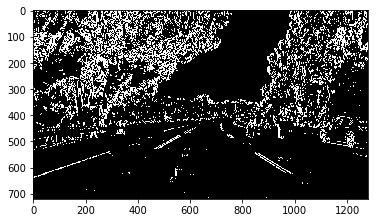

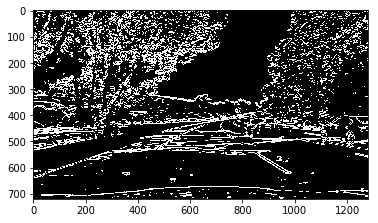

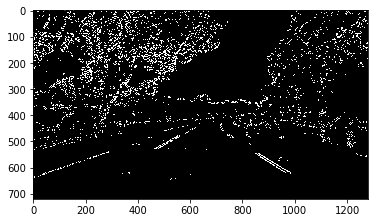

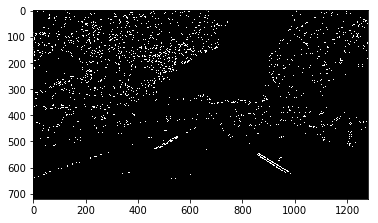

In [214]:
img = images[6]
plt.imshow(img)
plt.show()

gradx = abs_sobel_thresh(img, 'x', sobel_kernel=9, thresh=(20, 100))
plt.imshow(gradx, cmap='gray')
plt.show()

grady = abs_sobel_thresh(img, 'y', sobel_kernel=9, thresh=(20, 100))
plt.imshow(grady, cmap='gray')
plt.show()

# combine
binary = np.zeros_like(gradx)
binary[((gradx == 1) & (grady == 1))] = 1
plt.imshow(binary, cmap='gray')
plt.show()

"""
# filter magnitude
mag_binary = mag_thresh(img, mag_thresh=(20, 100))
plt.imshow(mag_binary, cmap='gray')
plt.show()
"""

# filter direction
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.8, 1.2))
#plt.imshow(dir_binary, cmap='gray')
#plt.show()

"""
binary = np.zeros_like(gradx)
binary[((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(binary, cmap='gray')
plt.show()
"""


binary = np.zeros_like(gradx)
binary[((gradx == 1) & (grady == 1) & (dir_binary == 1))] = 1
plt.imshow(binary, cmap='gray')
plt.show()

#### 2.3 Combine Two Methods

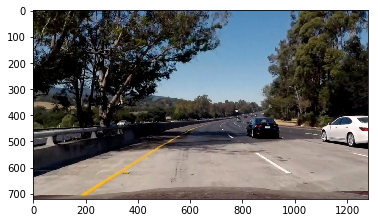

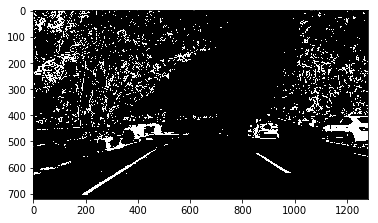

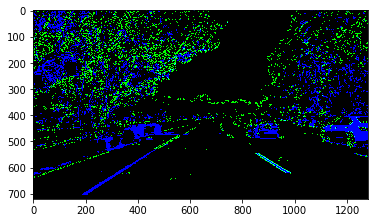

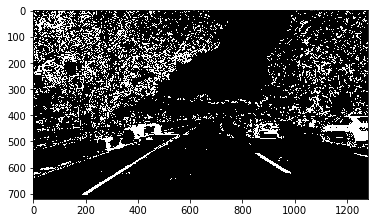

In [231]:
img = images[6]
plt.imshow(img)
plt.show()

# gradient method
gradx = abs_sobel_thresh(img, 'x', sobel_kernel=9, thresh=(20, 100))
grady = abs_sobel_thresh(img, 'y', sobel_kernel=9, thresh=(20, 100))
mag_binary = mag_thresh(img, mag_thresh=(20, 100))
dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.8, 1.2))

grad = np.zeros_like(gradx)
#grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
grad[((gradx == 1) & (grady == 1))] = 1

# Color selection
color = color_thresh(img, s_thresh=(170, 255), r_thresh=(220, 255))
plt.imshow(color, cmap='gray')
plt.show()

# Combine
stack_binary = np.dstack((np.zeros_like(grad), grad*255, color*255))
plt.imshow(stack_binary)
plt.show()

out = np.zeros_like(gradx)
out[(grad == 1) | (color == 1)] = 1
plt.imshow(out, cmap = 'gray')
plt.show()

It's evident that by combining both the color selection and gradient filter method, the output binary image can reserve most of the lane pixels under various of circumstances! Now let's apply these filters to all test images.

In [236]:
def cvt_binary_img(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=9, thresh=(20, 100))
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=9, thresh=(20, 100))
    mag_binary = mag_thresh(img, mag_thresh=(20, 100))
    dir_binary = dir_thresh(img, sobel_kernel=15, thresh=(0.8, 1.2))
    
    grad = np.zeros_like(gradx)
    #grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    grad[((gradx == 1) & (grady == 1))] = 1

    # Color selection
    color = color_thresh(img, s_thresh=(170, 255), r_thresh=(220, 255))

    # Combine two methods
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color == 1)] = 1
    return binary_img

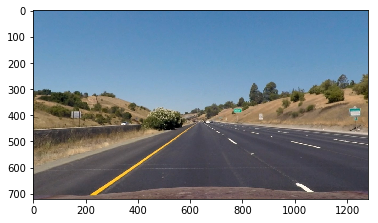

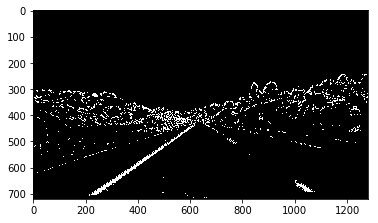

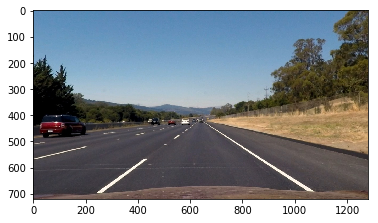

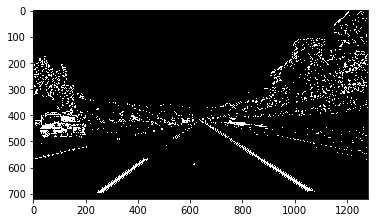

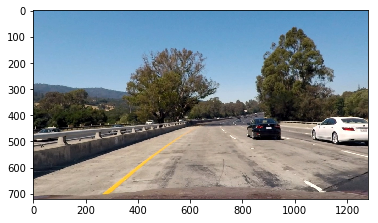

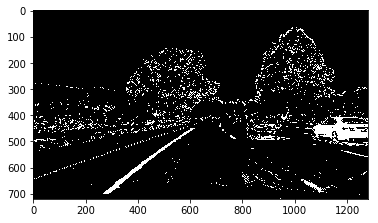

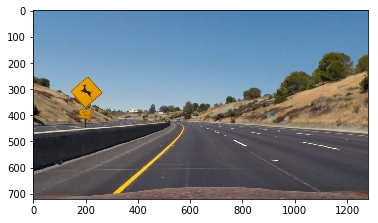

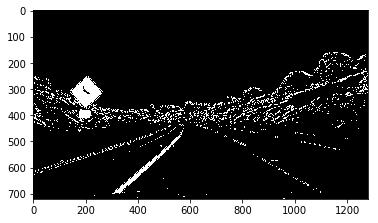

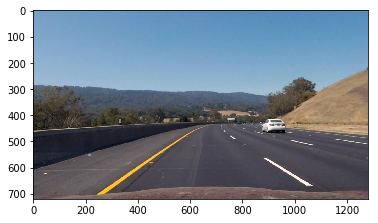

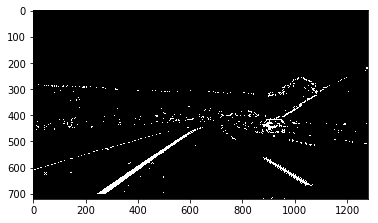

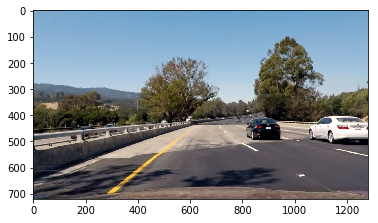

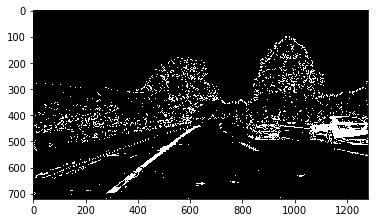

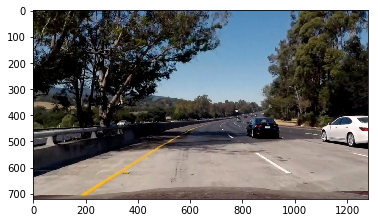

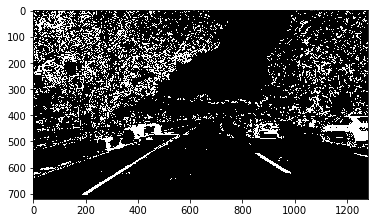

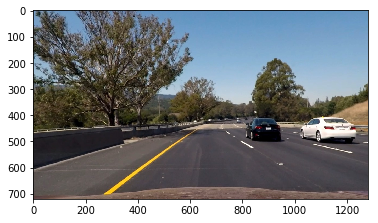

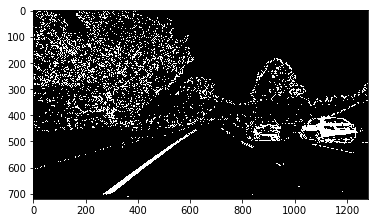

In [237]:
binary_images = []
for image in images:
    binary_image = cvt_binary_img(image)
    #fig = plt.figure()
    #fig.add_subplot(1,2,1)
    plt.imshow(image)
    plt.show()
    #fig.add_subplot(1,2,2)
    plt.imshow(binary_image, cmap='gray')
    plt.show()
    binary_images.append(binary_image)

### 3. Perspective Transform

After we get a binary image that contains lane lines, we gonna perform a perspective transform to the image and it will be rectified to a "birds-eye view".

A straight road is choosed to verify the transformation.

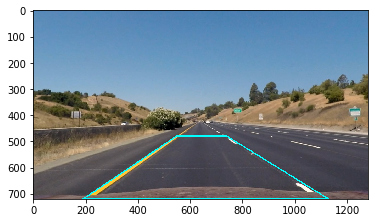

In [310]:
image = images[0]

copy = np.copy(image)

xLen = copy.shape[1]
yLen = copy.shape[0]
ht = 480
#src = np.float32([[yLen, offset1], [400, offset2], [400, xLen-offset2], [yLen, xLen-offset1]])
src = np.float32([[190, yLen], [548, ht], [740, ht], [xLen-150, yLen]])
lines = cv2.polylines(copy, np.int32([src]), True, (0, 255, 255), 3)
plt.imshow(lines)
plt.show()

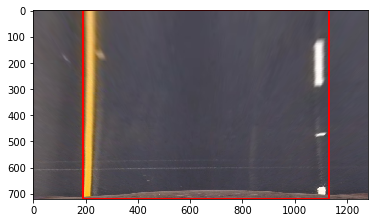

In [311]:
dst = np.float32([[190, yLen], [190, 0], [xLen-150, 0], [xLen-150, yLen]])

M = cv2.getPerspectiveTransform(src, dst)
image_size = (image.shape[1], image.shape[0])
warped = cv2.warpPerspective(image, M, image_size, cv2.INTER_LINEAR)

# Draw lines
lines = cv2.polylines(warped, np.int32([dst]), True, (255, 0, 0), 3)
plt.imshow(lines)
plt.show()

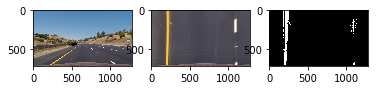

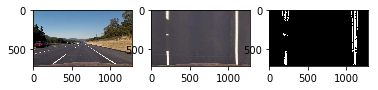

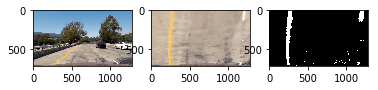

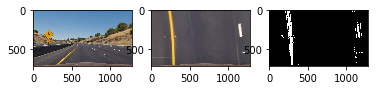

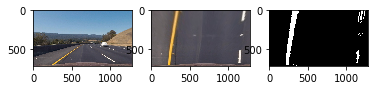

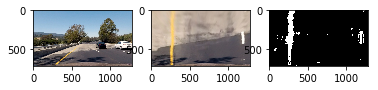

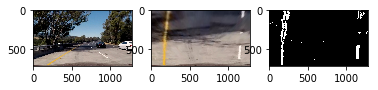

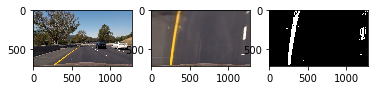

In [312]:
warp_images = []
warp_binary_images = []
for i in range(len(images)):
    image = images[i]
    image_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_size, cv2.INTER_LINEAR)
    warp_images.append(warped)
    
    binary_image = binary_images[i]
    warp_binary = cv2.warpPerspective(binary_image, M, image_size, cv2.INTER_LINEAR)
    warp_binary_images.append(warp_binary)
    
    fig = plt.figure()
    fig.add_subplot(1,3,1)
    plt.imshow(image)
    fig.add_subplot(1,3,2)
    plt.imshow(warped)
    fig.add_subplot(1,3,3)
    plt.imshow(warp_binary, cmap = 'gray')
    plt.show()

In [404]:
def color_thresh(img, s_thresh=(0, 255), r_thresh=(0,255)):
    # Deal with yellow
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    #plt.imshow(s_binary, cmap = 'gray')
    #plt.show()
    
    # Deal with white
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    #plt.imshow(r_binary, cmap = 'gray')
    #plt.show()
    
    binary = np.zeros_like(s_channel)
    binary[(s_binary == 1) | (r_binary == 1)] = 1
    return binary

In [412]:
def cvt_binary_img(img):
    # gradient method
    gradx = abs_sobel_thresh(img, 'x', sobel_kernel=3, thresh=(30, 255))
    #plt.imshow(gradx, cmap='gray')
    #plt.show()
    
    grady = abs_sobel_thresh(img, 'y', sobel_kernel=3, thresh=(20, 255))
    #plt.imshow(grady, cmap='gray')
    #plt.show()
    
    mag_binary = mag_thresh(img, mag_thresh=(20, 100))
    #plt.imshow(mag_binary, cmap='gray')
    #plt.show()
    
    dir_binary = dir_thresh(img, sobel_kernel=11, thresh=(0, 300))
    #plt.imshow(dir_binary, cmap='gray')
    #plt.show()
    
    grad = np.zeros_like(gradx)
    #grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #grad[((gradx == 1) & (grady == 1)) | (mag_binary == 1)] = 1
    grad[(gradx == 1)] = 1

    # Color selection
    color = color_thresh(img, s_thresh=(170, 255), r_thresh=(220, 255))

    # Combine two methods
    binary_img = np.zeros_like(gradx)
    binary_img[(grad == 1) | (color == 1)] = 1
    return binary_img

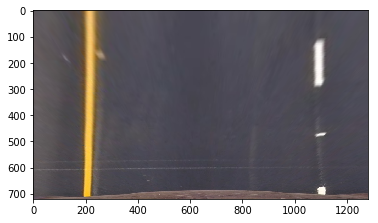

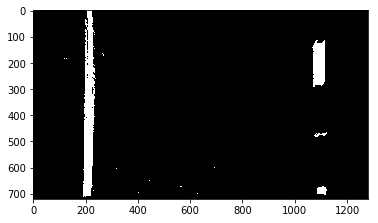

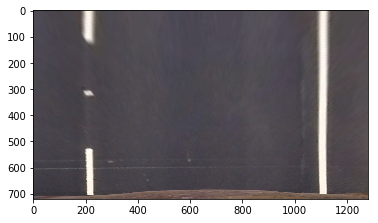

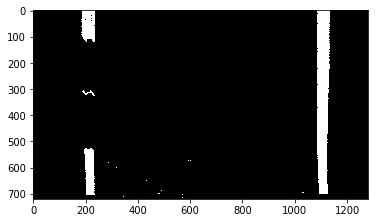

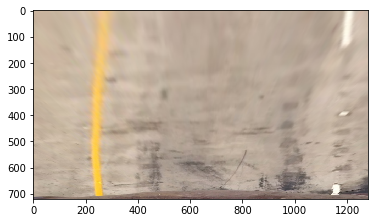

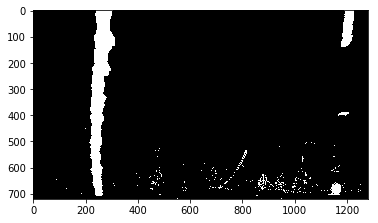

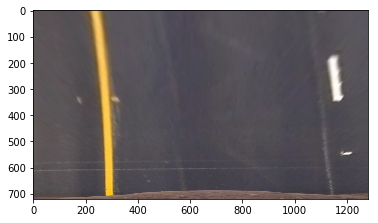

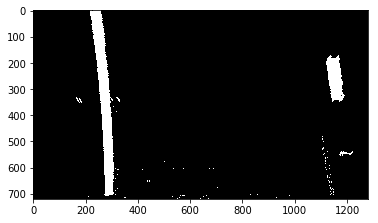

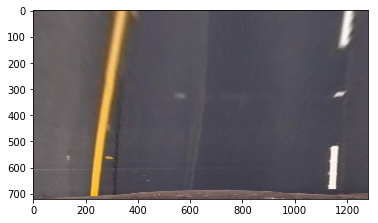

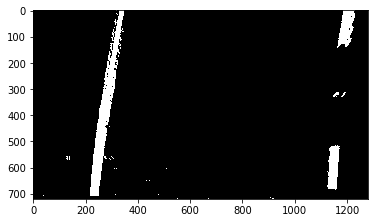

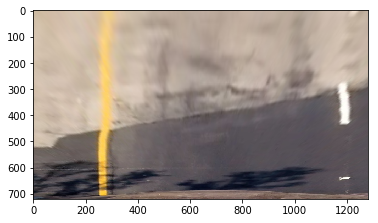

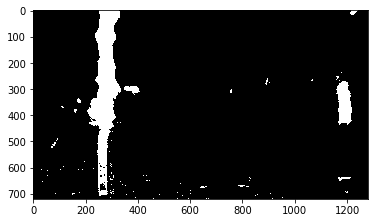

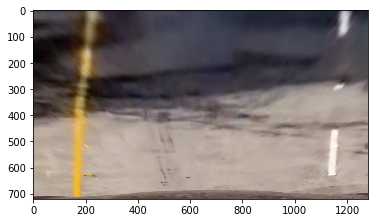

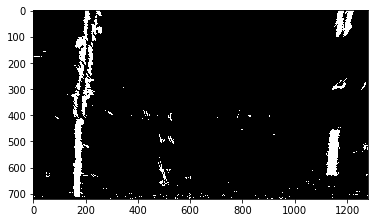

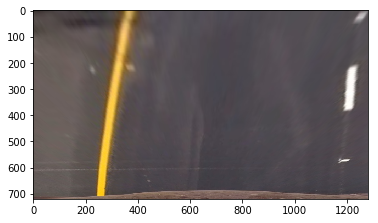

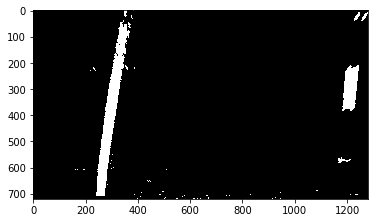

In [413]:
warp_binary_images = []
#tmp = [warp_images[6]]
for image in warp_images:
    plt.imshow(image)
    plt.show()
    
    """
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    for i in range(3):
        plt.imshow(hls[:,:,i], cmap='gray')
        plt.show()
        
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for i in range(3):
        plt.imshow(hsv[:,:,i], cmap='gray')
        plt.show()
    """
    
    
    binary_image = cvt_binary_img(image)
    plt.imshow(binary_image, cmap='gray')
    plt.show()
    binary_images.append(binary_image)
    warp_binary_images.append(binary_image)

### 4. Find Lane Pixels

In order to locate the lane pixels, we basically take two of the most prominent peaks in the histogram in each sliding window. I firstly tried the convolution method to search the window, it doesn't do a great job in the test images. I then use a more sophisticated method, which is also provided by the Udacity lesson, and that works well. 

#### 4.1 Convolution method:

In [414]:
# ------------------------------------ Credit from Udacity -----------------------------------------

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

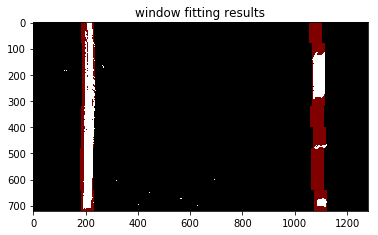

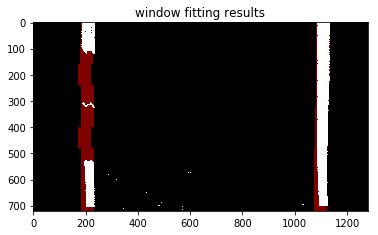

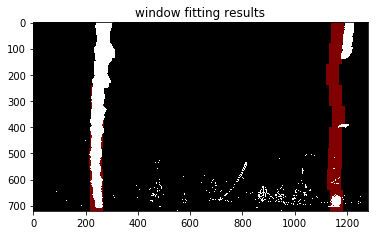

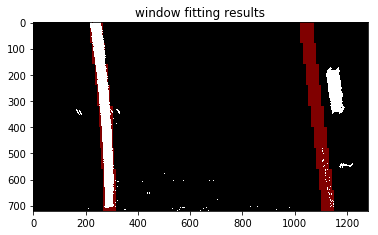

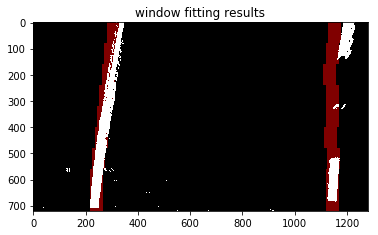

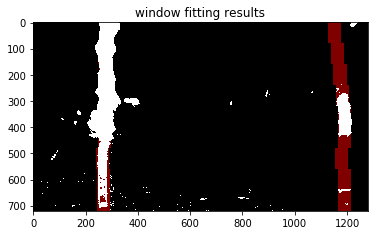

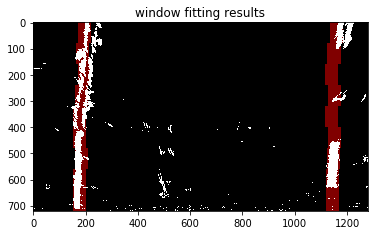

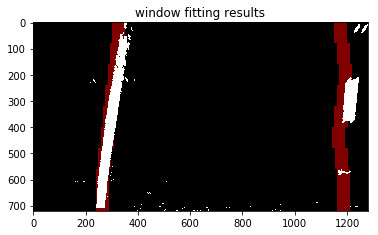

In [451]:
# ------------------------------------ Credit from Udacity -----------------------------------------

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 10 # How much to slide left and right for searching

for warped in warp_binary_images:
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | (l_mask == 1)] = 255
            r_points[(r_points == 255) | (r_mask == 1)] = 255

        # Draw the results
        warpage = np.array(cv2.merge((255*warped,255*warped,255*warped)),np.uint8) # making the original road pixels 3 color channels
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((template, zero_channel,zero_channel)),np.uint8) # make window pixels green
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()


#### 4.2 More Sophisticated Algorithm

Here's a more advanced algorithm to locate the lane pixels. In this algorithm, it only recenter the search window when the number of pixels are larger than the minimum required pixels located in the previous window. This produces a more stable output.

In [457]:
# ------------------------------------ Credit from Udacity -----------------------------------------

def find_lane_line(binary_warped, nwindows=9, margin=100, minpix=50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Highlight lane pixels and draw fit polynomials
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)
    plt.show()

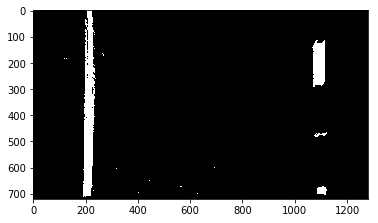

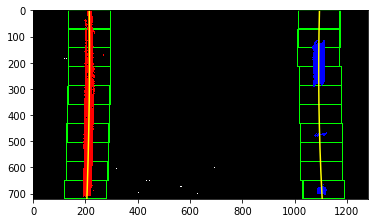

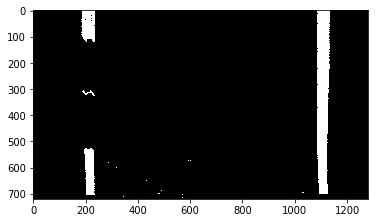

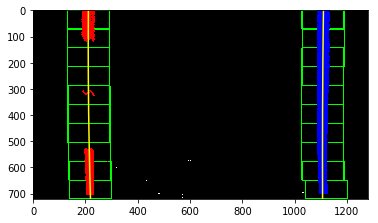

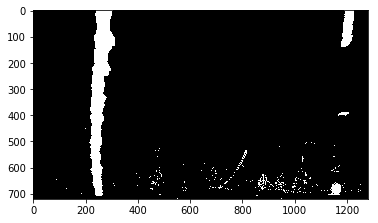

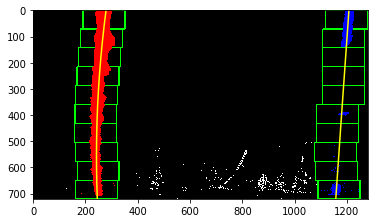

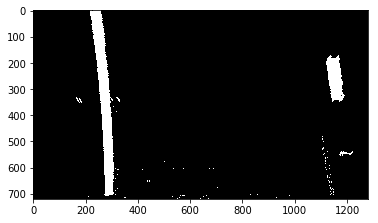

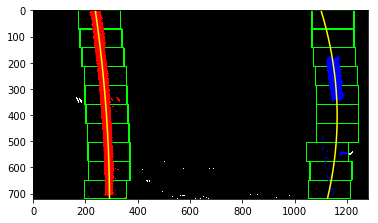

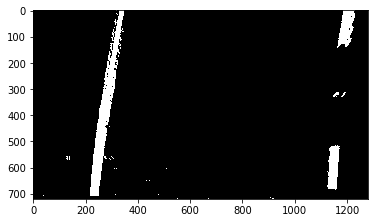

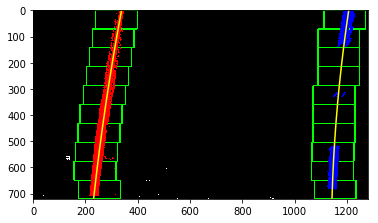

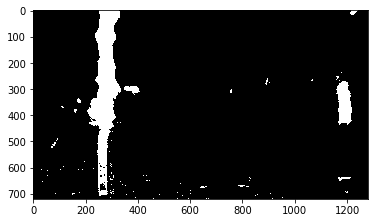

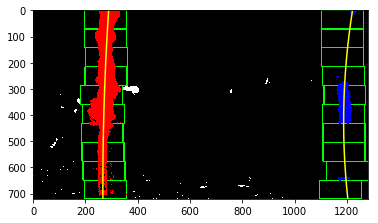

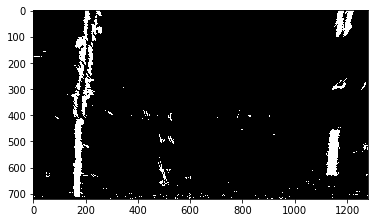

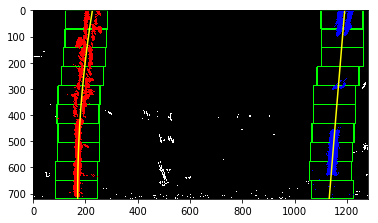

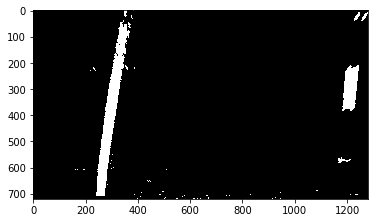

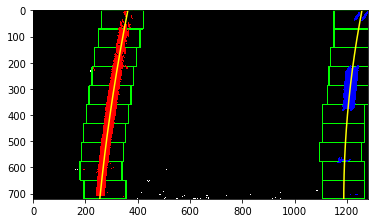

In [461]:
for binary_warped in warp_binary_images:
    plt.imshow(binary_warped, cmap='gray')
    plt.show()
    find_lane_line(binary_warped, nwindows=10, margin=80, minpix=50)